Дневник

1) Сначала проаналтзируем данные, видим что у нас есть 116 категориалных колонок, 14 числовых и таргет, все данные анонимны и нормированы, пропусков нет, есть аномально большие бины в распределении числовых, таргет логорифмический. Пишем базовый регрессор лгб на RMSE и получаем 1960. 

2) Попробуем написать кастомный лосс, фукнция дана, осталось только реализовать. По началу она как будто делает только хуже, но если настроить параметры, то профит действительно есть. Немного тюним параметры лгб и в совокупности получаем 1917. 

3) Проводим те же машинации с катбустом, лосс в нем должен возвращять антиградиент. Не вышло подобрать параметры лосса, так что просто тюним и получаем 1929.

4) Запилим мой любимый блендинг, просто усредним ответы и получаем 1912. Сместим предпочтение в сторону лгб и получаем 1910. 

5) Пришла интересная идея - есть некоторые ответы на которых предсказания лгб и катбуста совсем разные. Так вот в таких случаях нужно отдать предпочтение катбусту. Такой подход позволяет повысить качество и дает 1907. 

Вынес важный урок - иногда нужно воспроизвести результаты или получитьи предсказания не только теста, но и трейна. Было бы неплохо не только сохранять лучшие сабмиты, но и модели. 

Все работа - это несколько разный файлов, единого пайплайна нет. 

In [12]:
import base64
from IPython.display import Image, display, HTML

def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        return base64.b64encode(img_file.read()).decode()

# Конвертируем изображение в base64
shaps = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw4\\imgs\\shaps.jpg")
umap = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw4\\imgs\\UMAP.png")
diff = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw4\\imgs\\diff.png")
cat_lgb = image_to_base64("C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw4\\imgs\\cat_lgb.png")

----------------------------------

Сначала оптимизация лгбм

In [ ]:
import numpy as np 

def custom_epsilon_loss_grad_hess(y_raw, tr_data=None, y_true=None, alpha=1.2, beta=0.9, epsilon=1, p=2):
    # Получаем истинные значения
    if y_true is None:
        y_true = tr_data.get_label()
    
    # Проверка размерностей
    assert len(y_raw) == len(y_true), f"Размеры не совпдают: y_raw {len(y_raw)}, y_true {len(y_true)}"
    
    residuals = y_raw - y_true
    
    # Диагностика: выводим статистику по остаткам
    #print("\nДиагностика лосса:")
    #print(f"Сырые предсказания: min={np.min(y_raw):.2f}, max={np.max(y_raw):.2f}")
    #print(f"Истинные значения: min={np.min(y_true):.2f}, max={np.max(y_true):.2f}")
    #print(f"Остатки: min={np.min(residuals):.2f}, max={np.max(residuals):.2f}")
    
    # Инициализация градиента и гессиана
    grad = np.zeros_like(residuals)
    hess = np.zeros_like(residuals)
    
    # Маски для разных случаев
    within_epsilon = np.abs(residuals) <= epsilon
    overestimation = residuals > epsilon
    underestimation = residuals < -epsilon
    
    #print(f"Точек в epsilon: {np.sum(within_epsilon)}")
    #print(f"Переоценок: {np.sum(overestimation)}")
    #print(f"Недооценок: {np.sum(underestimation)}")
    
    # Вычисление градиента
    grad[overestimation] = alpha * p * (residuals[overestimation] - epsilon)**(p-1)
    grad[underestimation] = -beta * p * (-residuals[underestimation] - epsilon)**(p-1)
    
    # Вычисление гессиана
    if p > 1:
        hess[overestimation] = alpha * p * (p-1) * (residuals[overestimation] - epsilon)**(p-2)
        hess[underestimation] = beta * p * (p-1) * (-residuals[underestimation] - epsilon)**(p-2)
    
    # Защита от численной нестабильности
    grad = np.nan_to_num(grad, nan=0.0, posinf=0.0, neginf=0.0)
    hess = np.nan_to_num(hess, nan=0.0, posinf=0.0, neginf=0.0)
    
    #print(f"Градиент: min={np.min(grad):.2f}, max={np.max(grad):.2f}")
    #print(f"Гессиан: min={np.min(hess):.2f}, max={np.max(hess):.2f}")
    
    return grad, hess

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from functools import partial


import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

features = list(train.drop('target', axis=1).columns)
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

for feat in cat_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

X_train, X_val, y_train, y_val = train_test_split(
    train[features], train['target'], test_size=0.2, random_state=42
)

train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
val_dataset = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=train_dataset)

def objective(trial):
    params = {
        'objective': partial(custom_epsilon_loss_grad_hess,
                       alpha=1.4,      # штраф за переоценку
                       beta=1.55,      # штраф за недооценку
                       epsilon=25,
                       p=1.83
    	),
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }
    
    model = lgb.train(
        params,
        train_dataset,
        valid_sets=[val_dataset],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150, timeout=2*60*60)

print('Best trial:')
trial = study.best_trial
print(f'  RMSE: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_params = trial.params
best_params['objective'] = 'regression'

full_train_dataset = lgb.Dataset(train[features], label=train['target'], categorical_feature=cat_features)
final_model = lgb.train(best_params, full_train_dataset)

test['target'] = final_model.predict(test[features])
test[['index', 'target']].to_csv('test.csv', index=False)

Самые адекватные параметры в итоге вот такие

    'num_leaves': 141, 'learning_rate': 0.06952548413655923, 'feature_fraction': 0.41, 'bagging_fraction': 0.96,
    'bagging_freq': 2, 'min_child_samples': 36, 'lambda_l1': 1.0109188816655285e-05, 'lambda_l2': 0.39692590506186837

Те что не перебрались выставлялись эмпирически. 

Обучаем с такими параметрами но на кросс валидации

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import mean_squared_error
from functools import partial

import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')
features = list(train.drop('target', axis=1).columns)

cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

for feat in cat_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

params = {
    'objective': partial(custom_epsilon_loss_grad_hess,
                       alpha=1.4,
                       beta=1.55,
                       epsilon=25,
                       p=1.83
    ),
    'num_leaves': 141,
    'learning_rate': 0.06952548413655923,
    'feature_fraction': 0.41,
    'bagging_fraction': 0.96,
    'bagging_freq': 2,
    'min_child_samples': 36,
    'lambda_l1': 1.0109188816655285e-05,
    'lambda_l2': 0.39692590506186837,
    'metric': 'rmse',
    'verbose': -1
}

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(train))
models = []

# Кросс-валидация
for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    print(f"Fold {fold + 1}/{n_folds}")
    
    # Разделение данных
    X_train, X_val = train.iloc[train_idx][features], train.iloc[val_idx][features]
    y_train, y_val = train.iloc[train_idx]['target'], train.iloc[val_idx]['target']
    
    train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_set = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=train_set)
    
    # Обучение модели
    model = lgb.train(
        params=params,
        train_set=train_set,
        valid_sets=[train_set, val_set],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    models.append(model)
    oof_predictions[val_idx] = model.predict(X_val)
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, oof_predictions[val_idx]))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}\n")

total_rmse = np.sqrt(mean_squared_error(train['target'], oof_predictions))
print(f"Overall OOF RMSE: {total_rmse:.4f}")

# Преобразование категориальных признаков в тестовом наборе
for feat in cat_features:
    test[feat] = test[feat].astype('category')

test_predictions = np.zeros(len(test))
for model in models:
    test_predictions += model.predict(test[features])
test_predictions /= n_folds

test['target'] = test_predictions
test[['index', 'target']].to_csv('lgb_cv_after_opt_custom_loss.csv', index=False)

Fold 1/5
Fold 1 RMSE: 1869.7163

Fold 2/5
Fold 2 RMSE: 1864.4636

Fold 3/5
Fold 3 RMSE: 1922.5247

Fold 4/5
Fold 4 RMSE: 1837.0233

Fold 5/5
Fold 5 RMSE: 1946.0490

Overall OOF RMSE: 1888.3812
CPU times: total: 3min 54s
Wall time: 21.5 s

----------------------------------

Еще был вариант лгб когда я лобавлял кнн признаки, но такой подход делалш только хуже. Делал так - нужно после обучения получить из шапов 3 лучший числовых признака, именно них и датасет передаем в knn функцию.

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import numpy as np

def add_knn_features(
    dataset: pd.DataFrame,
    features_for_knn: list,
    n_neighbors: int = 5,
    add_distance_stats: bool = True,
    add_neighbor_stats: bool = True
) -> pd.DataFrame:
    """
    Добавляет KNN-признаки в датасет на основе указанных признаков.
    
    Параметры:
    ----------
    dataset : pd.DataFrame
        Исходный датасет
    features_for_knn : list
        Список признаков, по которым искать соседей
    n_neighbors : int, optional
        Количество соседей для KNN (по умолчанию 5)
    add_distance_stats : bool, optional
        Добавлять статистики по расстояниям (по умолчанию True)
    add_neighbor_stats : bool, optional
        Добавлять статистики по значениям соседей (по умолчанию True)
        
    Возвращает:
    -----------
    pd.DataFrame
        Датосет с добавленными KNN-признаками
    """
    df = dataset.copy()
    X = df[features_for_knn].values
    
    # Инициализация и обучение модели KNN
    knn = NearestNeighbors(n_neighbors=n_neighbors+1, metric='euclidean')
    knn.fit(X)
    
    distances, indices = knn.kneighbors(X)
    
    distances = distances[:, 1:]
    indices = indices[:, 1:]
    
    prefix = f'knn_k{n_neighbors}_'
    
    if add_distance_stats:
        # Добавляем статистики по расстояниям
        df[prefix + 'dist_mean'] = distances.mean(axis=1)
        df[prefix + 'dist_std'] = distances.std(axis=1)
        df[prefix + 'dist_min'] = distances.min(axis=1)
        df[prefix + 'dist_max'] = distances.max(axis=1)
        df[prefix + 'dist_median'] = np.median(distances, axis=1)
    
    if add_neighbor_stats:
        # Добавляем статистики по значениям соседей для каждого исходного признака
        for feature in features_for_knn:
            neighbor_values = df[feature].values[indices]
            
            df[prefix + f'{feature}_mean'] = neighbor_values.mean(axis=1)
            df[prefix + f'{feature}_std'] = neighbor_values.std(axis=1)
            df[prefix + f'{feature}_min'] = neighbor_values.min(axis=1)
            df[prefix + f'{feature}_max'] = neighbor_values.max(axis=1)
            df[prefix + f'{feature}_median'] = np.median(neighbor_values, axis=1)
    
    return df

Результат по шапам оставляет желать лучшего


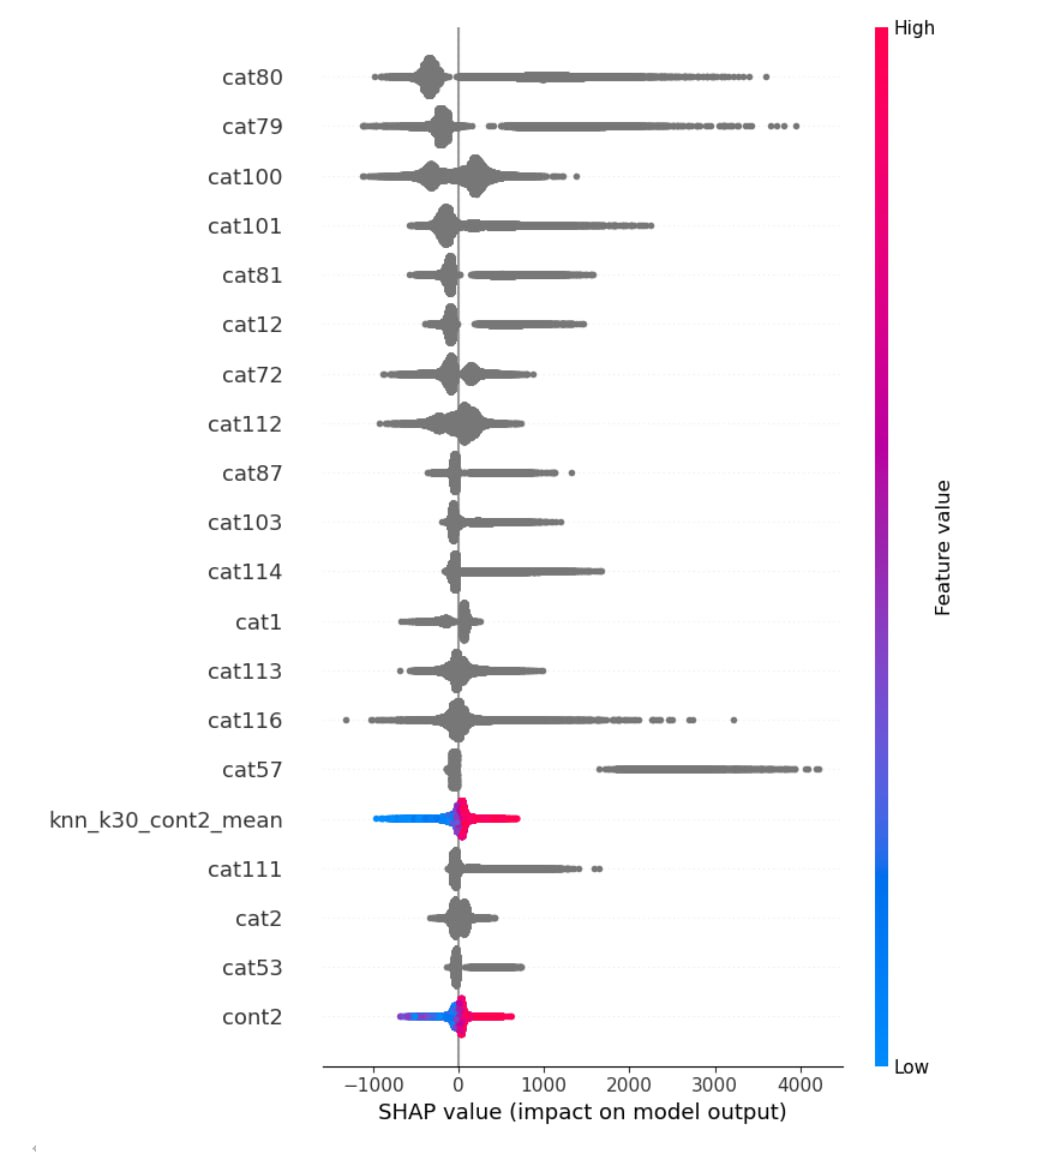

In [3]:
display(Image(url=f"data:image/jpg;base64,{shaps}"))

----------------------------------

Все тоже самое проделываем с катбустом

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import optuna
from catboost import CatBoostRegressor, Pool
import warnings

warnings.filterwarnings('ignore')

train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

features = list(train.drop('target', axis=1).columns)
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

'''for col in cat_features:
    freq = train[col].value_counts(normalize=True)
    rare_categories = freq[freq < 0.01].index
    train[col] = train[col].replace(rare_categories, 'Other')
    test[col] = test[col].replace(rare_categories, 'Other')'''
    
X_train, X_val, y_train, y_val = train_test_split(
    train[features], train['target'], test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'verbose': False,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': 42,
        'early_stopping_rounds': 50
    }
    
    model = CatBoostRegressor(**params)
    
    model.fit(
        train_pool,
        eval_set=val_pool,
        early_stopping_rounds=50,
        verbose=False
    )
    
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3*60*60)

print('Best trial:')
trial = study.best_trial
print(f'  RMSE: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

best_params = study.best_params
best_params.update({
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': False
})

full_train_pool = Pool(train[features], train['target'], cat_features=cat_features)
final_model = CatBoostRegressor(**best_params)
final_model.fit(full_train_pool)

test['target'] = final_model.predict(test[features])
test[['index', 'target']].to_csv('test_catboost.csv', index=False)

Best trial:
  RMSE: 1853.280729030385
  Params: 
    iterations: 1463
    learning_rate: 0.0898269619399365
    depth: 7

----------------------------------

Также как в прошлый раз переобучаем все на CV

In [4]:
class EpsilonLossObjective(object):
    def __init__(self, alpha=1.2, beta=0.9, epsilon=1.0, p=2):
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        self.p = p
    
    def calc_ders_range(self, approxes, targets, weights):
        grad = np.zeros(len(targets), dtype=np.float64)
        hess = np.zeros(len(targets), dtype=np.float64)
        
        residuals = np.array(approxes) - np.array(targets)
        
        within_epsilon = np.abs(residuals) <= self.epsilon
        overestimation = residuals > self.epsilon
        underestimation = residuals < -self.epsilon
        
        # Градиент
        grad[overestimation] = self.alpha * self.p * (residuals[overestimation] - self.epsilon)**(self.p - 1)
        grad[underestimation] = -self.beta * self.p * (-residuals[underestimation] - self.epsilon)**(self.p - 1)
        
        # Гессиан (только если p > 1)
        if self.p > 1:
            hess[overestimation] = self.alpha * self.p * (self.p - 1) * (residuals[overestimation] - self.epsilon)**(self.p - 2)
            hess[underestimation] = self.beta * self.p * (self.p - 1) * (-residuals[underestimation] - self.epsilon)**(self.p - 2)
        
        # Защита от численной нестабильности
        grad = np.nan_to_num(grad, nan=0.0, posinf=0.0, neginf=0.0)
        hess = np.nan_to_num(hess, nan=0.0, posinf=0.0, neginf=0.0)
        
        return list(zip(grad, hess))

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from functools import partial

# Загрузка данных
train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

# Подготовка данных
features = list(train.drop('target', axis=1).columns)
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Преобразование категориальных признаков
cat_features = train.select_dtypes(include=['object', 'category']).columns.tolist()

for feat in cat_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

In [ ]:
# Лучшие параметры из Optuna
best_params = {
    #'loss_function': EpsilonLossObjective(alpha=1.4, beta=1.55, epsilon=25, p=1.83),
    'loss_function': 'RMSE',
    'iterations': 1146,
    'learning_rate': 0.09652479858727847,
    'depth': 7,
    'l2_leaf_reg': 4.13,
    'random_strength': 0.07,
    'bagging_temperature': 0.56,
    'leaf_estimation_iterations': 7,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': False
}

# Кросс-валидация
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))
scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(train[features]), 1):
    X_train, X_valid = train[features].iloc[train_idx], train[features].iloc[valid_idx]
    y_train, y_valid = train['target'].iloc[train_idx], train['target'].iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    
    model = CatBoostRegressor(**best_params)
    model.fit(
        train_pool,
        eval_set=valid_pool,
        early_stopping_rounds=50,
        verbose=False
    )
    
    valid_pred = model.predict(X_valid)
    oof_preds[valid_idx] = valid_pred
    test_preds += model.predict(test[features]) / n_folds
    
    rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    scores.append(rmse)
    print(f'Fold {fold} RMSE: {rmse:.4f}')

print(f'\nAverage RMSE across folds: {np.mean(scores):.4f}')
print(f'Standard deviation: {np.std(scores):.4f}')

full_train_pool = Pool(train[features], train['target'], cat_features=cat_features)
final_model = CatBoostRegressor(**best_params)
final_model.fit(full_train_pool)

test['target'] = final_model.predict(test[features])
test[['index', 'target']].to_csv('catboost_cv_after_opt.csv', index=False)

Как было сказано такой подход дает 1929

----------------------------------

Была попытка добавить пару новых столбцов - компоненты UMAP. Результата не дало.

In [ ]:
def add_umap_clusters(train_df, test_df, n_components=2, n_clusters=5, random_state=42):
    """
    Добавляет UMAP проекцию и кластеры в train и test датасеты
    
    Параметры:
    ----------
    train_df : pandas.DataFrame
        Тренировочный датасет
    test_df : pandas.DataFrame
        Тестовый датасет
    n_components : int, optional (default=2)
        Число компонент для UMAP
    n_clusters : int, optional (default=5)
        Число кластеров для KMeans
    random_state : int, optional (default=42)
        Seed для воспроизводимости
        
    Возвращает:
    -----------
    tuple of (train_df, test_df, umap_model, kmeans_model)
        train_df и test_df с добавленными колонками UMAP и кластерами
        umap_model и kmeans_model для возможного применения к новым данным
    """
    
    train = train_df.copy()
    test = test_df.copy()
    
    # Добавляем индикаторные столбцы
    train['is_train'] = 1
    test['is_train'] = 0
    
    combined = pd.concat([train, test], axis=0)
    combined_scaled = combined.copy()
    
    # Обрабатываем категориальные признаки
    categ_cols = combined.select_dtypes(exclude='number').columns.drop('is_train', errors='ignore')
    for col in categ_cols:
        le = LabelEncoder()
        combined_scaled[col] = le.fit_transform(combined[col].astype(str))
    
    numeric_cols = combined.select_dtypes(include=[np.number]).columns.drop('is_train', errors='ignore')
    scaler = StandardScaler()
    
    # Заполняем пропуски
    for col in numeric_cols:
        if combined_scaled[col].isna().any():
            median_val = combined_scaled[col].median()
            combined_scaled[col] = combined_scaled[col].fillna(median_val)
    
    combined_scaled[numeric_cols] = scaler.fit_transform(combined_scaled[numeric_cols])
    features_for_umap = numeric_cols.union(categ_cols)
    
    # Проверяем на наличие пропусков перед UMAP
    if combined_scaled[features_for_umap].isna().any().any():
        raise ValueError("В данных остались пропущенные значения после обработки")
    
    # Применяем UMAP
    umap_model = umap.UMAP(n_components=n_components, random_state=random_state)
    umap_features = umap_model.fit_transform(combined_scaled[features_for_umap])
    
    # Кластеризуем с помощью KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(umap_features)
    
    # Добавляем UMAP компоненты и кластеры в объединенный датафрейм
    for i in range(n_components):
        combined[f'umap_{i+1}'] = umap_features[:, i]
    combined['cluster'] = clusters
    
    # Разделяем обратно на train и test
    train_with_clusters = combined[combined['is_train'] == 1].drop('is_train', axis=1)
    test_with_clusters = combined[combined['is_train'] == 0].drop('is_train', axis=1)
    
    if n_components >= 2:
        plot_df = pd.DataFrame({
            'umap_1': umap_features[:, 0],
            'umap_2': umap_features[:, 1],
            'cluster': clusters,
            'dataset': ['train']*len(train) + ['test']*len(test)
        })
        
        fig = px.scatter(plot_df, x='umap_1', y='umap_2', color='cluster',
                         symbol='dataset', title='UMAP Projection with Clusters',
                         hover_data={'umap_1': ':.2f', 'umap_2': ':.2f', 'cluster': True, 'dataset': True})
        fig.show()
    
    return train_with_clusters, test_with_clusters


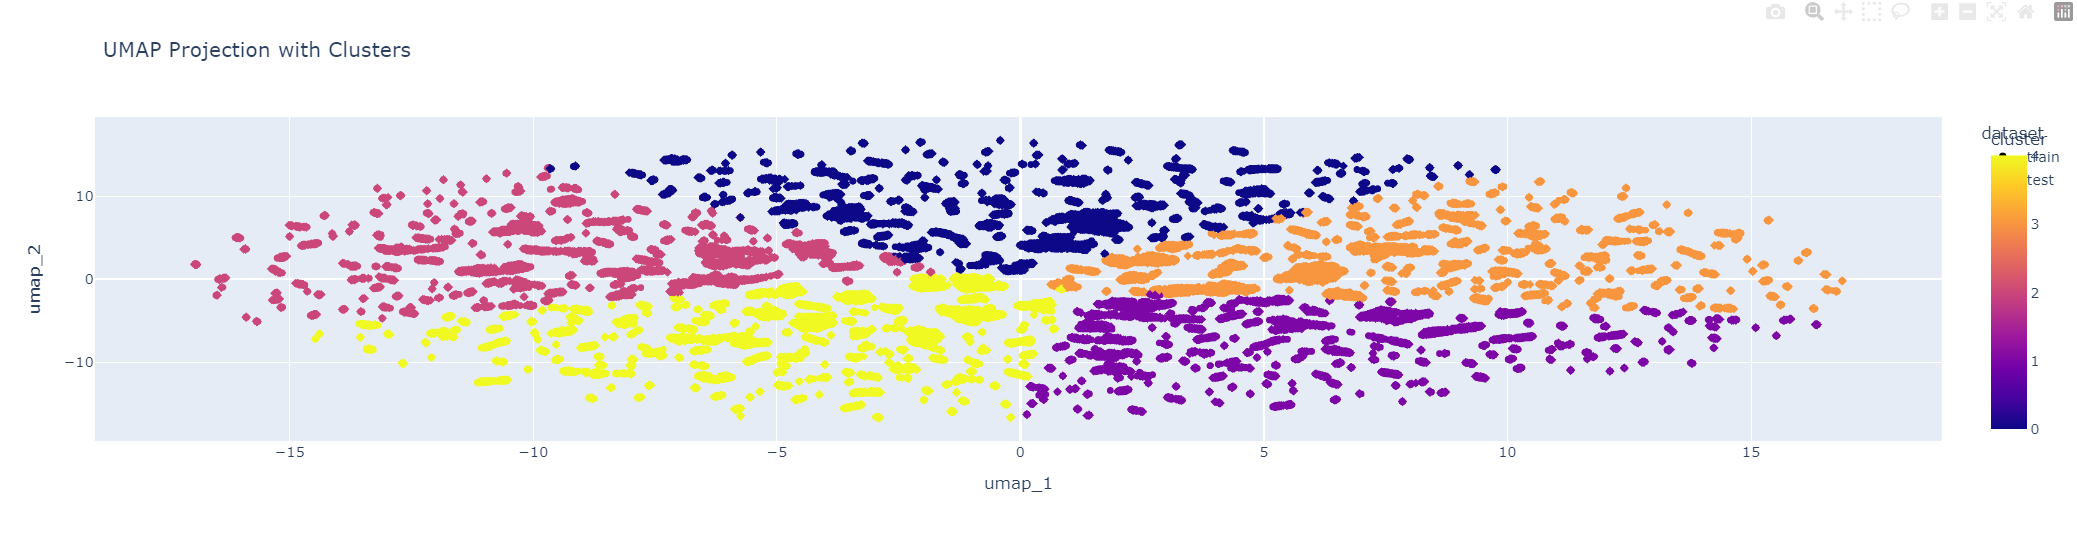

In [10]:
display(Image(url=f"data:image/jpg;base64,{umap}"))

----------------------------------

Была попытка написать ансамбль - получилась лажа

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

train = pd.read_csv('train_contest.csv')
test = pd.read_csv('test_contest.csv')

X = train.drop(columns=['target'])
y = train.target

index = test.index
test = test.drop(columns=['index'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
numeric_cols = [col for col in X.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ])

models = [
    # Линейные модели
    ('Ridge', Pipeline([('preprocessor', preprocessor), ('model', Ridge())])),
    ('Lasso', Pipeline([('preprocessor', preprocessor), ('model', Lasso())])),
    ('ElasticNet', Pipeline([('preprocessor', preprocessor), ('model', ElasticNet())])),
    
    # Деревянные ансамбли
    ('RandomForest', Pipeline([('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42))])),
    ('ExtraTrees', Pipeline([('preprocessor', preprocessor), ('model', ExtraTreesRegressor(n_estimators=100, max_depth=5, random_state=42))])),
    
    # Бустинги
    ('XGBoost', XGBRegressor(n_estimators=100, max_depth=3, enable_categorical=True, random_state=42)),
    ('LGBM', LGBMRegressor(n_estimators=100, max_depth=3, random_state=42)),
        
    # KNN
    ('KNN', Pipeline([('preprocessor', preprocessor), ('model', KNeighborsRegressor())])),
]

oof_predictions = {}
for name, model in models:
    try:
        oof_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1, verbose=0)
        rmse = np.sqrt(mean_squared_error(y, oof_pred))
        oof_predictions[name] = oof_pred
        print(f"{name} | RMSE: {rmse:.2f}")
    except Exception as e:
        print(f"Ошибка в {name}: {str(e)}")
        continue

X_meta = np.column_stack(list(oof_predictions.values()))

Ridge | RMSE: 2077.70

Lasso | RMSE: 2078.64

ElasticNet | RMSE: 2202.70

RandomForest | RMSE: 2206.47

ExtraTrees | RMSE: 2199.43

XGBoost | RMSE: 1944.72

LGBM | RMSE: 1957.08

KNN | RMSE: 2678.91

In [ ]:
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler()
X_meta_scaled = scaler.fit_transform(X_meta)

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsRegressor()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_meta_scaled, y)

print("Лучшие параметры KNN:", grid_search.best_params_)
print("Лучший RMSE:", -grid_search.best_score_)

best_knn = grid_search.best_estimator_

In [ ]:
from sklearn.base import clone
from joblib import parallel_backend

final_models = {}
for name, model in models:
    try:
        print(f"\nПереобучение {name} на всех данных...")
        
        if isinstance(model, Pipeline):
            new_model = clone(model)
        else:
            new_model = model.__class__(**model.get_params())
        
        if name in ['XGBoost', 'LGBM']:
            with parallel_backend('threading', n_jobs=-1):
                new_model.fit(X, y)
        else:
            new_model.fit(X, y)
            
        final_models[name] = new_model
        print(f"{name} успешно переобучен!")
        
    except Exception as e:
        print(f"Ошибка при переобучении {name}: {str(e)}")
        continue

def stack_predict(X_new):
    """
    Предсказание с использованием стекинга
    
    Параметры:
    X_new - новые данные (DataFrame или array-like)
    
    Возвращает:
    Предсказания мета-модели
    """
    preds = []
    for name, model in final_models.items():
        try:
            if name == 'XGBoost':
                X_new_xgb = X_new.copy()
                for col in categorical_cols:
                    if col in X_new_xgb.columns:
                        X_new_xgb[col] = X_new_xgb[col].astype('category')
                pred = model.predict(X_new_xgb)
            else:
                pred = model.predict(X_new)
            preds.append(pred)
        except Exception as e:
            print(f"Ошибка в {name} при предсказании: {str(e)}")
            continue
    
    X_meta_new = np.column_stack(preds)
    X_meta_new_scaled = scaler.transform(X_meta_new)
    
    return best_knn.predict(X_meta_new_scaled)

if 'test' in locals():
    try:
        print("\nПрогнозирование на тестовых данных...")
        test_predictions = stack_predict(test)
        print("Предсказания готовы! Пример первых 5 значений:")
        print(test_predictions[:5])
        
        pd.DataFrame({'prediction': test_predictions}).to_csv('stacking_predictions.csv', index=False)
        print("Предсказания сохранены в stacking_predictions.csv")
    except Exception as e:
        print(f"Ошибка при прогнозировании на тесте: {str(e)}")

----------------------------------

Действительно рабочая тема это блендинг - комбинируем предсказания с весами.

In [ ]:
import pandas as pd
import numpy as np

lgb_df = pd.read_csv('best/lgb1917.csv')
cat_df = pd.read_csv('best/cat1929.csv')
ens_df = pd.read_csv('best/ens1967.csv')

print(lgb_df['target'])
print(cat_df['target'])


lgb_weight = 0.63
cat_weight = 0.37

ans = pd.DataFrame({})

ans['index'] = lgb_df['index']
ans['target'] = (lgb_df['target'] * lgb_weight + cat_df['target'] * cat_weight)

print(ans['target'])

ans[['index', 'target']].to_csv(f'custom_loss_mean_cv_lgb_cat_{int(lgb_weight*100)}_{int(cat_weight*100)}.csv', index=False)

А потом я посмотрел и увидел что есть некоторые ответы на которых предсказания лгб и катбуста совсем разные. 

Так вот в таких случаях нужно отдать предпочтение катбусту. Такой подход позволяет повысить качество и дает 1907. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = lgb_df.copy()
df['lt'] = lgb_df['target']  # LightGBM
df['ct'] = cat_df['target']  # CatBoost
df = df.drop(columns=['target'])

df['63_37'] = (df['lt'] * 0.63 + df['ct'] * 0.37) #Простой блендинг

df['diff'] = df['63_37'] - df['ct'] # Разница предсказаний

threshold = 2000

df['target'] = np.where(
    abs(df['diff']) > threshold,
    df['63_37'] * 0.20 + df['ct']  * 0.80, #Если больше порога
    df['63_37']
)


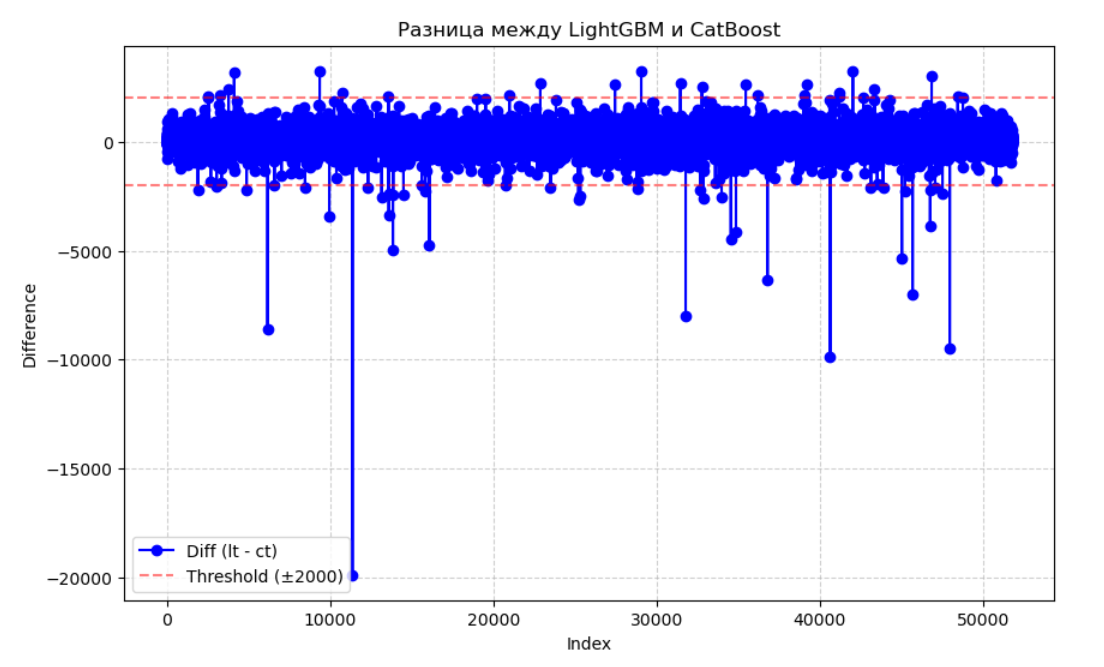

In [13]:
display(Image(url=f"data:image/jpg;base64,{diff}"))


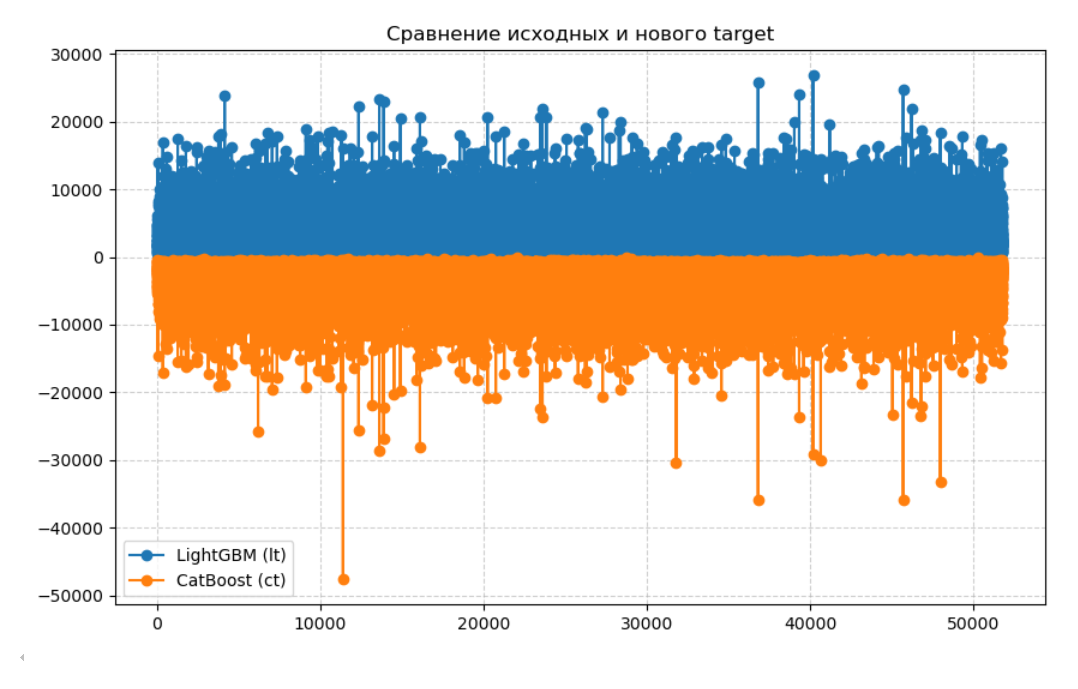

In [14]:
display(Image(url=f"data:image/jpg;base64,{cat_lgb}"))

----------------------------------

На этом все, спасибо за интересное соревнование!